## Read a on-prem data rod from a few segments and plot hourly time series at selected site

**Objectives**:

    - Obtain a data rod by reading a few shorter segmental datarods and concatenating them into a long datarod because the datarod service has a limination on the length for one try 
    - Plot the time series at the selected location (e.g., daily mean vs. climatology and the 90th percentile) 

**Data and data tools**
- Data: NLDAS Primary Forcing Data L4 Hourly 0.125 x 0.125 degree V2.0 [NLDAS_FORA0125_H_2.0](https://doi.org/10.5067/THUF4J1RLSYG) 
- Subset: Use the datarod API to subset the data on the fly at a point location [Link of datarod website](https://disc.gsfc.nasa.gov/information/tools?title=Hydrology%20Data%20Rods)
- Visualize: Use this Python script 

**Author and Contact**:
- Xiaohua Pan at NASA/GSFC/GES DISC (xiaohua.pan@nasa.gov)
- Last update: Feb. 27, 2024

**Disclaimer** 
- The code is for demonstration purposes only. Users are responsible to check for accuracy and revise to fit their objective.

#### Reference: 
- NASA GES DISC datarod website:https://disc.gsfc.nasa.gov/information/tools?title=Hydrology%20Data%20Rodshttps://disc.gsfc.nasa.gov/information/tools?title=Hydrology%20Data%20Rods 
- Accessing multiple files under the same URL (for the example below)
https://rabernat.github.io/research_computing_2018/xarray-tips-and-tricks.html
- Calculate anomaly
https://rabernat.github.io/research_computing_2018/xarray-tips-and-tricks.html
- Groupby processing
https://geohackweek.github.io/nDarrays/07-groupby-processing/
- Dail Time series Data Visualization in Python
https://towardsdatascience.com/a-complete-guide-to-time-series-data-visualization-in-python-da0ddd2cfb01
- xarray plotting and visualization
https://xarray-contrib.github.io/xarray-tutorial/scipy-tutorial/04_plotting_and_visualization.html
- Accessing GRB Data From Unidata THREDDS With Python
https://geonetcast.wordpress.com/2019/05/17/geonetclass-accessing-grb-data-from-unidata-thredds-with-python-part-i/
- xarray
http://xarray.pydata.org/en/stable/io.html#opendap
- merge data
https://datalab.marine.rutgers.edu/2020/05/merging-datasets-for-the-win-and-export/
- pandas change UTC to local time 
** https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.tz_localize.html;
** https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html
- text font size
https://matplotlib.org/stable/tutorials/text/text_intro.html
- time freq option (D-daily, M-monthly, or W-weekly...) 
https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-alias
- time series analysis
https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/


#### Prerequisites: 
- Install "xarray" package with conda run if you don't have one yet: 
    - conda install -c free xarray 

##### Formula to convert unit from Kelvin (K) to Fahrenheit (F)    
    var = (var - 273.15)*(9/5) + 32.0

### Import modules 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import date
import xarray as xr
import datetime
import requests 

import urllib
import urllib.parse as urlp
import io
import warnings
warnings.filterwarnings("ignore")

print("xr.__version__:", xr.__version__)
print("requests.__version__:", requests.__version__)
%matplotlib inline

xr.__version__: 2023.6.0
requests.__version__: 2.31.0


### Define functions that create the URLs for calling the time series service, and parses their ASCII text
Reference: [How to Access the Hydrology Data Rods Time Series API Using Python](https://github.com/nasa/gesdisc-tutorials/blob/main/notebooks/How_to_Access_the_Hydrology_Data_Rods_API_Using_Python.ipynb)

In [2]:
def get_time_series(start_date,end_date,latitude,longitude,variable):
    """
    Calls the data rods service to get a time series
    """
    base_url = "https://hydro1.gesdisc.eosdis.nasa.gov/daac-bin/access/timeseries.cgi"
    query_parameters = {
        "variable": variable,
        "type": "asc2",
        "location": f"GEOM:POINT({longitude}, {latitude})",
        "startDate": start_date,
        "endDate": end_date,
    }
    full_url = base_url+"?"+ \
         "&".join(["{}={}".format(key,urlp.quote(query_parameters[key])) for key in query_parameters])
    print(full_url)
    iteration = 0
    done = False
    while not done and iteration < 5:
        r=requests.get(full_url)
        if r.status_code == 200:
            done = True
        else:
            iteration +=1
    
    if not done:
        raise Exception(f"Error code {r.status_code} from url {full_url} : {r.text}")
    
    return r.text

def parse_time_series(ts_str):
    """
    Parses the response from data rods.
    """
    lines = ts_str.split("\n")
    parameters = {}
    for line in lines[2:11]:
        key,value = line.split("=")
        parameters[key] = value
    
    
    df = pd.read_table(io.StringIO(ts_str),sep="\t",
                       names=["time","data"],
                       header=10,parse_dates=["time"])
    return parameters, df

### Call the time series data rods service with our requested URLs
This query will return the center point of the closest grid:

In [3]:
# This data is generated by TDS over a region 
# -----------------------------------
# Make your choices in plotting data
# ----------------------------------
project_name='NLDAS2'
product_name='NLDAS_FORA0125_H_v2.0'
#product_name='NLDAS_NOAH0125_H'
#product_version='v2.0'

# Information of this collection 
# NLDAS_FORA0125_H_v2.0
# Spatial Coverage:-125.0,25.0,-67.0,53.0
# Temporal Coverage:1979-01-01 to  present 
# File Size:2 MB per file
# Data Resolution
#  Spatial:0.125 ° x 0.125 °
#  Temporal:1 hour

# sel_site_names = ['Phoenix', 'Houston']
# sel_site_lons = ['-112.0740', '-95.3698']
# sel_site_lats = ['33.4484', '29.7604' ]
# sel_site_colors = ['darkblue', 'orangered']
# sel_site_colors2 = ['royalblue', 'pink']

sel_site_names = ['Phoenix']
sel_site_lons = ['-112.0740']
sel_site_lats = ['33.4484' ]
sel_site_colors = ['darkblue']

sel_site_names = ['Houston'] 
sel_site_lats = ['29.77']
sel_site_lons = ['-95.37']
sel_site_colors = ['darkblue']

sel_site_names = ['Calgary'] # Canada
sel_site_lats = ['51.04']
sel_site_lons = ['-114.07']
sel_site_colors = ['darkblue']


# Get a long datarod from three shorter segments because the datarod service has a limitation
# Segment 1 
start_datetime_seg1 = "1990-01-01T00"
end_datetime_seg1 = "1998-12-31T23"

# Segment 2
start_datetime_seg2 = "1999-01-01T00"
end_datetime_seg2 = "2007-12-31T23"

# Segment 3
start_datetime_seg3 = "2008-01-01T00"
end_datetime_seg3 = "2016-12-31T23"

# Segment 4
start_datetime_seg4 = "2017-01-01T00"
end_datetime_seg4 = "2023-12-31T23"

#local_time_zone = 'US/Central'

# Select variable to plot
sel_var_shortname = 'Tair'

### Read segments seperately 

In [4]:
%%time
# Read the segment 1 of the datarod 
df_site0_seg1 = parse_time_series(
            get_time_series(
                start_date=start_datetime_seg1, 
                end_date=end_datetime_seg1,
                latitude=sel_site_lats[0],
                longitude=sel_site_lons[0],
                variable=f"{project_name}:{product_name}:{sel_var_shortname}"
            )
        )

df_site0_seg1[1]['data']

https://hydro1.gesdisc.eosdis.nasa.gov/daac-bin/access/timeseries.cgi?variable=NLDAS2%3ANLDAS_FORA0125_H_v2.0%3ATair&type=asc2&location=GEOM%3APOINT%28-114.07%2C%2051.04%29&startDate=1990-01-01T00&endDate=1998-12-31T23
CPU times: user 94.9 ms, sys: 41.5 ms, total: 136 ms
Wall time: 30.5 s


0        274.08
1        273.88
2        273.68
3        273.48
4        273.15
          ...  
78883    263.35
78884    264.00
78885    264.64
78886    264.87
78887    265.09
Name: data, Length: 78888, dtype: float64

In [5]:
# Calculate the time difference to double check the length of df_site0_seg1
# convert string to date object
# format: https://www.geeksforgeeks.org/python-datetime-strptime-function/
d1 = datetime.datetime.strptime(start_datetime_seg1, "%Y-%m-%dT%H")  
d2 = datetime.datetime.strptime(end_datetime_seg1, "%Y-%m-%dT%H") 

# difference between dates in timedelta
delta = d2 - d1 
print('d1=', d1) 
print('d2=', d2) 

# days and hours between two dates
print(f'{delta.days + 1} days between d1 and d2')
print(f'{(delta.days +1) * 24} hours between d1 and d2')

d1= 1990-01-01 00:00:00
d2= 1998-12-31 23:00:00
3287 days between d1 and d2
78888 hours between d1 and d2


In [6]:
%%time
# Read the segment 2 of the datarod 
df_site0_seg2 = parse_time_series(
            get_time_series(
                start_date=start_datetime_seg2, 
                end_date=end_datetime_seg2,
                latitude=sel_site_lats[0],
                longitude=sel_site_lons[0],
                variable=f"{project_name}:{product_name}:{sel_var_shortname}"
            )
        )

df_site0_seg2[1]['data']

https://hydro1.gesdisc.eosdis.nasa.gov/daac-bin/access/timeseries.cgi?variable=NLDAS2%3ANLDAS_FORA0125_H_v2.0%3ATair&type=asc2&location=GEOM%3APOINT%28-114.07%2C%2051.04%29&startDate=1999-01-01T00&endDate=2007-12-31T23
CPU times: user 95.8 ms, sys: 31.4 ms, total: 127 ms
Wall time: 28.2 s


0        265.31
1        266.44
2        267.58
3        268.71
4        268.30
          ...  
78883    265.46
78884    265.94
78885    266.43
78886    265.41
78887    264.40
Name: data, Length: 78888, dtype: float64

In [7]:
# Calculate the time difference to double check the length of df_site0_seg2
# convert string to date object
# format: https://www.geeksforgeeks.org/python-datetime-strptime-function/
d1 = datetime.datetime.strptime(start_datetime_seg2, "%Y-%m-%dT%H")  
d2 = datetime.datetime.strptime(end_datetime_seg2, "%Y-%m-%dT%H") 

# difference between dates in timedelta
delta = d2 - d1 
print('d1=', d1) 
print('d2=', d2) 

# days and hours between two dates
print(f'{delta.days + 1} days between d1 and d2')
print(f'{(delta.days +1) * 24} hours between d1 and d2')

d1= 1999-01-01 00:00:00
d2= 2007-12-31 23:00:00
3287 days between d1 and d2
78888 hours between d1 and d2


In [8]:
%%time
# Read the segment 3 of the datarod 
df_site0_seg3 = parse_time_series(
            get_time_series(
                start_date=start_datetime_seg3, 
                end_date=end_datetime_seg3,
                latitude=sel_site_lats[0],
                longitude=sel_site_lons[0],
                variable=f"{project_name}:{product_name}:{sel_var_shortname}"
            )
        )

df_site0_seg3[1]['data']

https://hydro1.gesdisc.eosdis.nasa.gov/daac-bin/access/timeseries.cgi?variable=NLDAS2%3ANLDAS_FORA0125_H_v2.0%3ATair&type=asc2&location=GEOM%3APOINT%28-114.07%2C%2051.04%29&startDate=2008-01-01T00&endDate=2016-12-31T23
CPU times: user 99.1 ms, sys: 31.8 ms, total: 131 ms
Wall time: 27.5 s


0        263.38
1        262.71
2        262.04
3        261.37
4        261.40
          ...  
78907    269.01
78908    269.21
78909    269.41
78910    268.84
78911    268.26
Name: data, Length: 78912, dtype: float64

In [9]:
# Calculate the time difference to double check the length of df_site0_seg3
# convert string to date object
# format: https://www.geeksforgeeks.org/python-datetime-strptime-function/
d1 = datetime.datetime.strptime(start_datetime_seg3, "%Y-%m-%dT%H")  
d2 = datetime.datetime.strptime(end_datetime_seg3, "%Y-%m-%dT%H") 

# difference between dates in timedelta
delta = d2 - d1 
print('d1=', d1) 
print('d2=', d2) 

# days and hours between two dates
print(f'{delta.days + 1} days between d1 and d2')
print(f'{(delta.days +1) * 24} hours between d1 and d2')

d1= 2008-01-01 00:00:00
d2= 2016-12-31 23:00:00
3288 days between d1 and d2
78912 hours between d1 and d2


In [10]:
%%time
# Read the segment 4 of the datarod 
df_site0_seg4 = parse_time_series(
            get_time_series(
                start_date=start_datetime_seg4, 
                end_date=end_datetime_seg4,
                latitude=sel_site_lats[0],
                longitude=sel_site_lons[0],
                variable=f"{project_name}:{product_name}:{sel_var_shortname}"
            )
        )

df_site0_seg4[1]['data']

https://hydro1.gesdisc.eosdis.nasa.gov/daac-bin/access/timeseries.cgi?variable=NLDAS2%3ANLDAS_FORA0125_H_v2.0%3ATair&type=asc2&location=GEOM%3APOINT%28-114.07%2C%2051.04%29&startDate=2017-01-01T00&endDate=2023-12-31T23
CPU times: user 89.4 ms, sys: 24.4 ms, total: 114 ms
Wall time: 25.7 s


0        267.68
1        267.37
2        267.06
3        266.75
4        266.50
          ...  
61339    277.60
61340    277.68
61341    277.76
61342    277.30
61343    276.85
Name: data, Length: 61344, dtype: float64

In [11]:
# Calculate the time difference to double check the length of df_site0_seg3
# convert string to date object
# format: https://www.geeksforgeeks.org/python-datetime-strptime-function/
d1 = datetime.datetime.strptime(start_datetime_seg4, "%Y-%m-%dT%H")  
d2 = datetime.datetime.strptime(end_datetime_seg4, "%Y-%m-%dT%H") 

# difference between dates in timedelta
delta = d2 - d1 
print('d1=', d1) 
print('d2=', d2) 

# days and hours between two dates
print(f'{delta.days + 1} days between d1 and d2')
print(f'{(delta.days +1) * 24} hours between d1 and d2')

d1= 2017-01-01 00:00:00
d2= 2023-12-31 23:00:00
2556 days between d1 and d2
61344 hours between d1 and d2


In [12]:
# Check if the ending time of the last segment is consistent with the specification 
df_site0_seg4[1]['time']

0       2017-01-01 00:00:00
1       2017-01-01 01:00:00
2       2017-01-01 02:00:00
3       2017-01-01 03:00:00
4       2017-01-01 04:00:00
                ...        
61339   2023-12-31 19:00:00
61340   2023-12-31 20:00:00
61341   2023-12-31 21:00:00
61342   2023-12-31 22:00:00
61343   2023-12-31 23:00:00
Name: time, Length: 61344, dtype: datetime64[ns]

In [13]:
# Print the parameter part 
df_site0_seg1[0]

{'prod_name': 'NLDAS_FORA0125_H_v2.0',
 'param_short_name': 'Tair',
 'param_name': '2-meter above ground Temperature',
 'unit': 'K',
 'begin_time': '1990-01-01T00',
 'end_time': '1998-12-31T23',
 'lat': ' 51.0625',
 'lon': '-114.062',
 'Request_time': '2024-02-09 20:58:40 GMT'}

### Concatenate segments into a dataframe

In [14]:
# Get variable attribute
sel_var_longname = df_site0_seg1[0]['param_name']
sel_var_unit = df_site0_seg1[0]['unit'] 

In [15]:
# concatenated = pandas.concat([df1, df2])
d = {'time': pd.to_datetime( pd.concat([df_site0_seg1[1]['time'], df_site0_seg2[1]['time'], df_site0_seg3[1]['time'], df_site0_seg4[1]['time'] ] ), unit='s'), 
    sel_site_names[0]: pd.concat([df_site0_seg1[1]['data'], df_site0_seg2[1]['data'], df_site0_seg3[1]['data'], df_site0_seg4[1]['data'] ]), 
    #sel_site_names[1]: df_site1[1]['data']
    }
    
df = pd.DataFrame(data=d)
df

,time,Calgary
0,1990-01-01 00:00:00,274.08
1,1990-01-01 01:00:00,273.88
2,1990-01-01 02:00:00,273.68
3,1990-01-01 03:00:00,273.48
4,1990-01-01 04:00:00,273.15
...,...,...
61339,2023-12-31 19:00:00,277.60
61340,2023-12-31 20:00:00,277.68
61341,2023-12-31 21:00:00,277.76
61342,2023-12-31 22:00:00,277.30


In [16]:
df['time'].values

array(['1990-01-01T00:00:00.000000000', '1990-01-01T01:00:00.000000000',
       '1990-01-01T02:00:00.000000000', ...,
       '2023-12-31T21:00:00.000000000', '2023-12-31T22:00:00.000000000',
       '2023-12-31T23:00:00.000000000'], dtype='datetime64[ns]')

In [17]:
# convert unit from Kelvin (K) to Fahrenheit (F) 
#    formula: var_F = (var_K - 273.15)*(9/5) + 32.0 
sel_var_unit2 = ''
if sel_var_shortname == 'Tair' and sel_var_unit == 'K':
    #df2= (df - 273.15)*(9/5) + 32.0  # Not work
    df2 = (df[sel_site_names] - 273.15)*(9/5) + 32.0
    sel_var_unit2 = 'F'
    # frozen_temperature
    y_ref = 32.0 
df2

,Calgary
0,33.674
1,33.314
2,32.954
3,32.594
4,32.000
...,...
61339,40.010
61340,40.154
61341,40.298
61342,39.470


In [18]:
# Add the column "Datetime"
df2['Datetime'] = df['time'].values
df2 = df2.set_index('Datetime')
df2.head(1000)                            

,Calgary
Datetime,
1990-01-01 00:00:00,33.674
1990-01-01 01:00:00,33.314
1990-01-01 02:00:00,32.954
1990-01-01 03:00:00,32.594
1990-01-01 04:00:00,32.000
...,...
1990-02-11 11:00:00,32.774
1990-02-11 12:00:00,32.594
1990-02-11 13:00:00,32.522


In [19]:
# Resample the hourly data into daily data
# reference: https://medium.com/@zumaia/resample-timeseries-in-python-2f90108cbbf2
df2_site0_daily = df2[sel_site_names[0]].resample('d').mean()
df2_site0_daily

Datetime
1990-01-01    30.88400
1990-01-02    25.87475
1990-01-03    20.93375
1990-01-04    23.42825
1990-01-05    26.09750
                ...   
2023-12-27    33.29450
2023-12-28    35.58350
2023-12-29    34.81100
2023-12-30    34.58900
2023-12-31    39.21275
Freq: D, Name: Calgary, Length: 12418, dtype: float64

In [20]:
# Put it into dataframe
d3 = {'Datetime': df2_site0_daily.index, 
    sel_site_names[0]: df2_site0_daily.values, 
    }
    
df3 = pd.DataFrame(data=d3)
df3 = df3.set_index('Datetime')
df3

,Calgary
Datetime,
1990-01-01,30.88400
1990-01-02,25.87475
1990-01-03,20.93375
1990-01-04,23.42825
1990-01-05,26.09750
...,...
2023-12-27,33.29450
2023-12-28,35.58350
2023-12-29,34.81100


In [21]:
# Get daily Climatology (mean, 95th, and 5th) 
clim_beg = "1991-01-01"
clim_end = "2020-12-31"
df2_site0_daily_30yr = df2_site0_daily.loc[clim_beg:clim_end]
df2_site0_daily_30yr

df2_site0_daily_30yr_mean = df2_site0_daily_30yr.groupby(df2_site0_daily_30yr.index.dayofyear).mean()
df2_site0_daily_30yr_mean

Datetime
1      18.008250
2      19.817600
3      19.182275
4      18.891400
5      17.525600
         ...    
362    19.453675
363    18.187000
364    16.334225
365    16.110825
366    13.649938
Name: Calgary, Length: 366, dtype: float64

In [22]:
df2_site0_daily_30yr_90th = df2_site0_daily_30yr.groupby(df2_site0_daily_30yr.index.dayofyear).quantile(0.90)
df2_site0_daily_30yr_90th

Datetime
1      29.938175
2      31.989050
3      35.704850
4      35.682350
5      33.280625
         ...    
362    35.029025
363    35.332925
364    30.036650
365    29.317100
366    28.219625
Name: Calgary, Length: 366, dtype: float64

In [23]:
# The number of days for rolling mean  
ndays_rolling_mean = 14 
df2_site0_daily_30yr_mean_smooth = df2_site0_daily_30yr_mean.rolling(window=ndays_rolling_mean, center=True, min_periods=5).mean()
df2_site0_daily_30yr_mean_smooth
df2_site0_daily_30yr_90th_smooth = df2_site0_daily_30yr_90th.rolling(window=ndays_rolling_mean, center=True, min_periods=5).mean()
df2_site0_daily_30yr_90th_smooth

Datetime
1      33.480811
2      33.543969
3      33.771358
4      33.784723
5      33.745182
         ...    
362    33.593581
363    33.568959
364    33.731915
365    33.493567
366    33.082334
Name: Calgary, Length: 366, dtype: float64

In [24]:
df2_site0_daily_30yr_mean.index

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            357, 358, 359, 360, 361, 362, 363, 364, 365, 366],
           dtype='int64', name='Datetime', length=366)

 Pick up your figure  ./fig/datarod_NLDAS_FORA0125_H_v2.0.Yearly_Comparison_Tair_Calgary.png


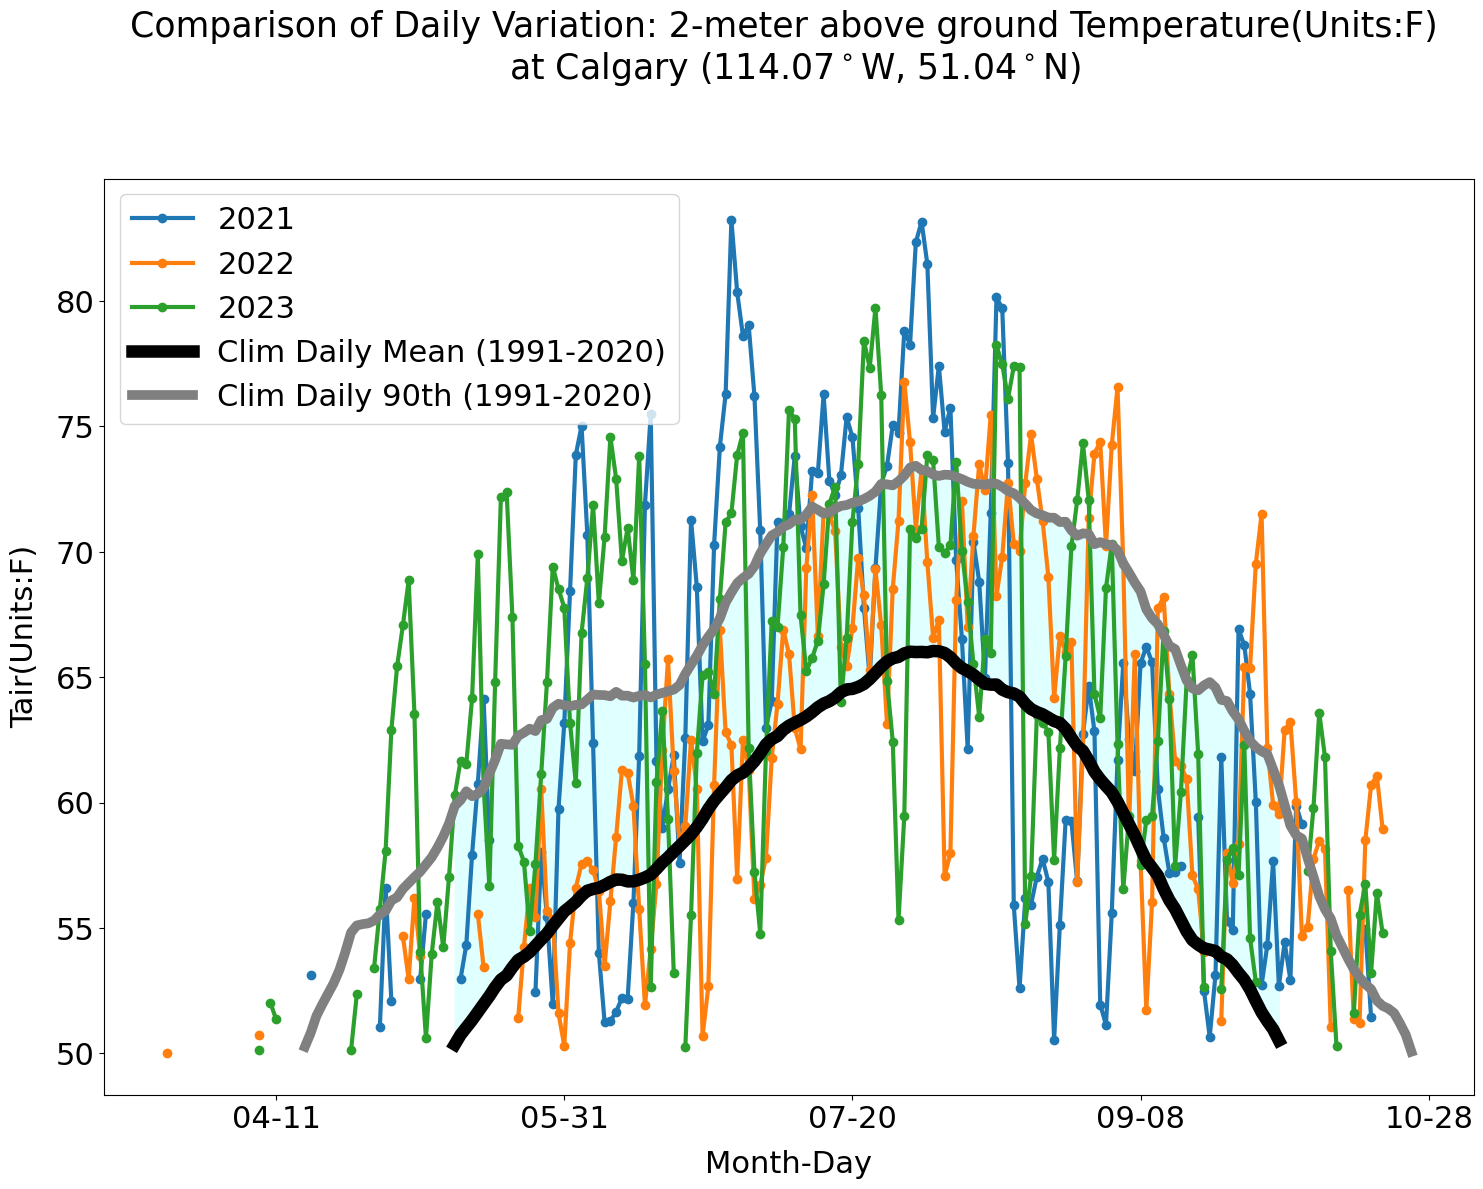

In [25]:
# Plot the time series of Comparison of Daily Variation over selected years
# Reference: https://stackoverflow.com/questions/61757333/how-to-plot-time-series-and-group-years-together
fig, ax = plt.subplots(figsize=(15, 12))
#plt.rcParams.update(IPython_default)

# Reference: https://matplotlib.org/stable/gallery/color/named_colors.html
# Change the default face color
ax.set_facecolor("white")

# Make spine shown
for spine in ['bottom', 'left', 'top', 'right']:
    #ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('black')
    
#plt.style.use('classic')
#%matplotlib inline
# draw solid white grid lines
# Reference: https://matplotlib.org/stable/gallery/lines_bars_and_markers/linestyles.html
plt.grid(color='gray', linestyle='dotted')

# Create a date column from index (easier to manipulate)
df3["date_column"] = pd.to_datetime(df3.index)
# Create a year column
df3["year"] = df3["date_column"].dt.year
# Create a month-day column
# Create a month-day column
df3["month_day"] = (df3["date_column"].dt.month).astype(str).str.zfill(2) + \
                "-" + df3["date_column"].dt.day.astype(str).str.zfill(2)

# Plot. Pivot will create for each year a column and these columns will be used as series.

# plot all years
# df3.pivot('month_day', 'year', sel_site_names[0]).plot(kind='line', figsize=(12, 8), marker='o')

# plot only selected years
sel_date_beg = "2021-01-01"
sel_date_end = "2023-12-31"

# pivot function is used to reshaped a given DateFrame into a different shape. 
sel_plot = df3.loc[sel_date_beg:sel_date_end].pivot('month_day', 'year', sel_site_names[0])
sel_plot

# Define a temperature threshold then plot data only larger than this temperature threshold
if float(sel_site_lats[0]) >= 25. and float(sel_site_lats[0]) < 35.0:
    threshold = 75  # Taxes 
elif float(sel_site_lats[0]) >= 35. and float(sel_site_lats[0]) < 45.0:
    threshold = 65  # middle east states 
elif float(sel_site_lats[0]) >= 45. and  float(sel_site_lats[0]) < 60.0:
    threshold = 50  # Southern Canada
elif float(sel_site_lats[0]) >= 60. and  float(sel_site_lats[0]) < 90.0:
    threshold = 40  # Rest of Northern hemisphere 

# Plot the time series    
sel_plot.where(sel_plot >= threshold).plot(kind='line', linewidth=3, marker='o', markersize=6, grid=True,  ax=ax)

ax.tick_params(labelsize=22)

# Overplot climatology daily mean 
df2_site0_daily_30yr_mean_smooth.where(df2_site0_daily_30yr_mean_smooth >=threshold).plot(kind='line', linewidth=9, color='black', label = 'Clim Daily Mean (1991-2020)')
#plt.legend(loc='upper left', fontsize=20)

# Overplot climatology daily 95th
df2_site0_daily_30yr_90th_smooth.where(df2_site0_daily_30yr_90th_smooth >=threshold).plot(kind='line', linewidth=7, color='gray', label = 'Clim Daily 90th (1991-2020)')
plt.legend(loc='upper left', fontsize=22)

# Fill between two lines 
ax.fill_between(df2_site0_daily_30yr_mean_smooth.index, df2_site0_daily_30yr_mean_smooth.where(df2_site0_daily_30yr_mean_smooth >=threshold), df2_site0_daily_30yr_90th_smooth.where(df2_site0_daily_30yr_90th_smooth >= threshold), color='lightcyan',alpha=1) 

# Main title
# convert lon and lat strings to the traditional ones 
sel_site_lons_str = str(abs(float(sel_site_lons[0])))+'$^\circ$E'
if float(sel_site_lons[0]) < 0: 
    sel_site_lons_str = str(abs(float(sel_site_lons[0])))+'$^\circ$W'

sel_site_lats_str = str(abs(float(sel_site_lats[0])))+'$^\circ$N'
if float(sel_site_lats[0]) < 0: 
    sel_site_lats_str = str(abs(float(sel_site_lats[0])))+'$^\circ$S'
    
main_title = 'Comparison of Daily Variation: {}(Units:{}) \n at {} ({}, {})'.format(sel_var_longname,sel_var_unit2, sel_site_names[0], sel_site_lons_str, sel_site_lats_str)
plt.title(main_title, y=1.1, fontsize=25)
plt.xlabel("Month-Day", labelpad=12, fontsize=22)
plt.ylabel('{}(Units:{})'.format(sel_var_shortname,sel_var_unit2), labelpad=12,  fontsize=22);  

plt.tight_layout()

# Save the plot
figFile_plot = './fig/datarod_{}.Yearly_Comparison_{}_{}.png'.format(product_name, sel_var_shortname, sel_site_names[0])
fig.savefig(figFile_plot, dpi=300)
print(" Pick up your figure ", figFile_plot) 